In [11]:
from pathlib import Path
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 10)

PV_PATH = Path("/mnt/storage_b/data/ocf/solar_pv_nowcasting/nowcasting_dataset_pipeline/PV/Passiv/ocf_formatted/v0")
PV_DATA_PATH = PV_PATH / "passiv.netcdf"
PV_METADATA_PATH = PV_PATH / "system_metadata_OCF_ONLY.csv"

NWP_ZARR_PATH = Path("/mnt/storage_ssd_8tb/data/ocf/solar_pv_nowcasting/nowcasting_dataset_pipeline/NWP/UK_Met_Office/UKV/zarr/UKV_intermediate_version_3.zarr")

## Open and prepare PV data

In [12]:
pv_data = xr.open_dataset(PV_DATA_PATH)
pv_metadata = (
    pd.read_csv(PV_METADATA_PATH, index_col="system_id")
    .drop(columns=["Unnamed: 0", "ss_id", "llsoacd"])
)

In [13]:
pv_metadata

,orientation,tilt,kwp,operational_at,latitude,longitude
system_id,,,,,,
2405,180.0,35.0,3.36,2010-11-18,53.523772,-1.620456
2406,315.0,30.0,1.89,2010-12-03,54.883635,-1.379257
2407,225.0,30.0,1.89,2010-12-03,54.883635,-1.379257
2408,225.0,30.0,1.89,2010-12-03,54.883635,-1.379257
2409,225.0,30.0,1.89,2010-12-03,54.883635,-1.379257
...,...,...,...,...,...,...
27063,185.0,35.0,4.00,2018-04-18,51.406743,-2.484888
27064,180.0,45.0,2.00,2018-04-18,51.461223,-0.586961
27065,125.0,37.0,4.00,2018-04-18,51.362490,-2.927046


In [14]:
all_pv_system_ids = [
    int(system_id) for system_id in list(pv_data.variables.keys())
    if system_id != "datetime"
]

# Remove "day behind" PV systems from metadata:

all_pv_system_ids = pv_metadata.index.intersection(all_pv_system_ids)
pv_metadata = pv_metadata.loc[all_pv_system_ids]

In [15]:
# 1 has good data but very little shading (maybe just a tiny bit in the late-afternoon?)
# 3 has good data, and I think has more shading that 1 (in the morning)
# 5 has most shading so far
# 7 has no shading
# 8 has lots of shading
# 12 has no shading
# 13 has lots of shading!

pv_system_id = all_pv_system_ids[13]
pv_data_for_single_system = pv_data[str(pv_system_id)].to_pandas().dropna()

In [16]:
pv_data_for_single_system.index[0], pv_data_for_single_system.index[-1]

(Timestamp('2018-01-01 06:05:00'), Timestamp('2021-10-27 23:55:00'))

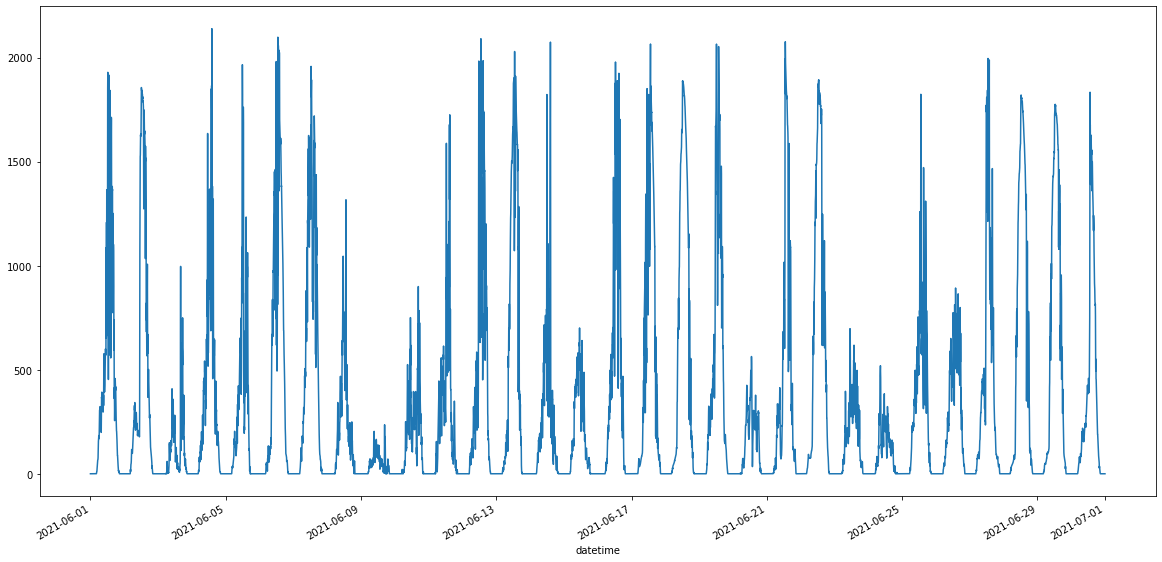

In [17]:
pv_data_for_single_system["2021-06"].plot();

In [18]:
data_for_plot = pv_data_for_single_system[pv_data_for_single_system.index.month == 7].to_frame("power")
data_for_plot["hour_of_day"] = data_for_plot.index.hour + (data_for_plot.index.minute / 60)

In [19]:
data_for_plot_pivotted = data_for_plot.pivot_table(
    index="hour_of_day",
    columns=data_for_plot.index.date,
    values="power",
)

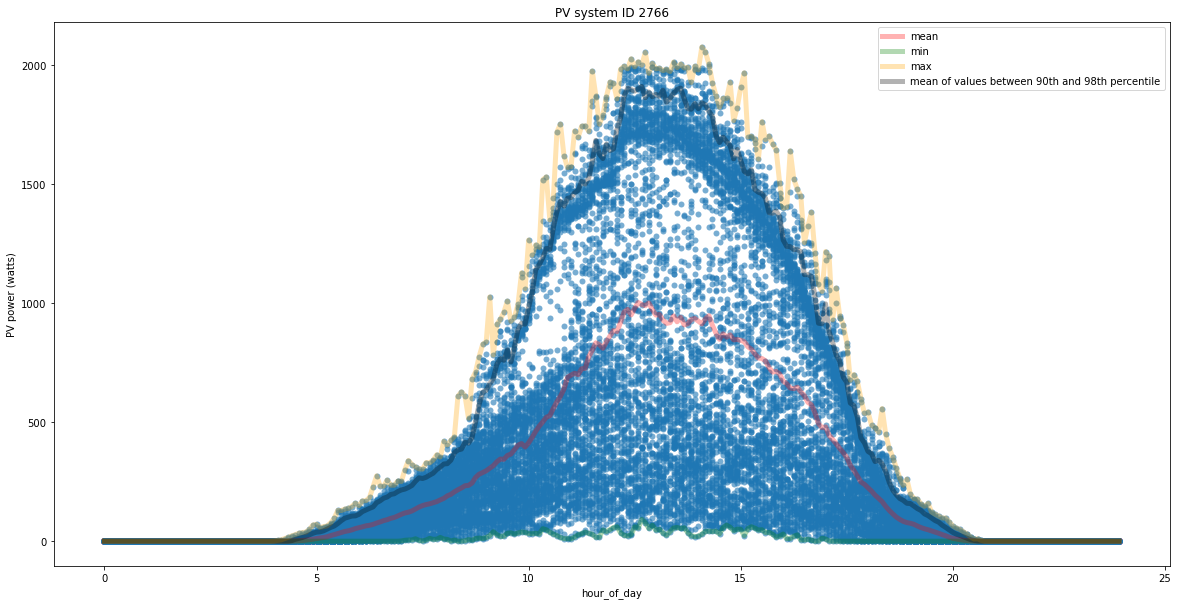

In [20]:
fig, ax = plt.subplots()
ax.scatter(
    x=data_for_plot["hour_of_day"],
    y=data_for_plot["power"],
    alpha=0.6,
    linewidths=0
)
line_plot_kwargs = dict(ax=ax, linewidth=5, alpha=0.3)
data_for_plot_pivotted.mean(axis="columns").plot(color="red", label="mean", **line_plot_kwargs)
data_for_plot_pivotted.min(axis="columns").plot(color="green", label="min", **line_plot_kwargs)
data_for_plot_pivotted.max(axis="columns").plot(color="orange", label="max", **line_plot_kwargs)

data_for_plot_pivotted[
    data_for_plot_pivotted.ge(data_for_plot_pivotted.quantile(q=0.90, axis="columns"), axis="index") &
    data_for_plot_pivotted.le(data_for_plot_pivotted.quantile(q=0.98, axis="columns"), axis="index")
].mean(axis="columns").plot(color="black", label="mean of values between 90th and 98th percentile", **line_plot_kwargs)

ax.set_title(f"PV system ID {pv_system_id}")
ax.set_ylabel("PV power (watts)")

ax.legend();

## pvlib

See [this StackOverflow answer for how to use pvlib for "generic" PV systems](https://stackoverflow.com/a/57169613/732596).

In [54]:
from pvlib import pvsystem, location, modelchain
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS

In [22]:
metadata_for_pv_system = pv_metadata.loc[pv_system_id]
metadata_for_pv_system

orientation            185.0
tilt                    30.0
kwp                     2.25
operational_at    2011-09-16
latitude           55.807096
longitude          -4.861087
Name: 2766, dtype: object

In [80]:
power_watts = max(
    pv_data_for_single_system.max(),
    metadata_for_pv_system.kwp * 1000,
)

module_parameters = dict(
    pdc0=power_watts,
    gamma_pdc=-0.004,  # from https://pvlib-python.readthedocs.io/en/stable/pvsystem.html
)

inverter_parameters = dict(
    pdc0=power_watts,
    # eta_inv_norm=0.96,  # from https://pvlib-python.readthedocs.io/en/stable/pvsystem.html
)

In [81]:
power_watts

2250.0

In [82]:
pv_system = pvsystem.PVSystem(
    surface_tilt=metadata_for_pv_system["tilt"],
    surface_azimuth=metadata_for_pv_system["orientation"],
    module_parameters=module_parameters,
    inverter_parameters=inverter_parameters,
    temperature_model_parameters=TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass'] # from: https://pvlib-python.readthedocs.io/en/stable/forecasts.html#pv-power-forecast
)
pv_system

PVSystem:
  name: None
  Array:
    name: None
    mount: FixedMount(surface_tilt=30.0, surface_azimuth=185.0, racking_model=None, module_height=None)
    module: None
    albedo: 0.25
    module_type: None
    temperature_model_parameters: {'a': -3.47, 'b': -0.0594, 'deltaT': 3}
    strings: 1
    modules_per_string: 1
  inverter: None

In [83]:
pv_location = location.Location(
    latitude=metadata_for_pv_system.latitude,
    longitude=metadata_for_pv_system.longitude,
    tz="Europe/London",
)
pv_location

Location: 
  name: None
  latitude: 55.80709595696567
  longitude: -4.861086566736806
  altitude: 0
  tz: Europe/London

In [84]:
model_chain = modelchain.ModelChain(
    system=pv_system,
    location=pv_location,
    dc_model="pvwatts",
    aoi_model="no_loss",
    spectral_model="no_loss",
)

In [85]:
pv_data_to_forecast = pv_data_for_single_system["2021-06"]

clearsky = pv_location.get_clearsky(times=pv_data_to_forecast.index)

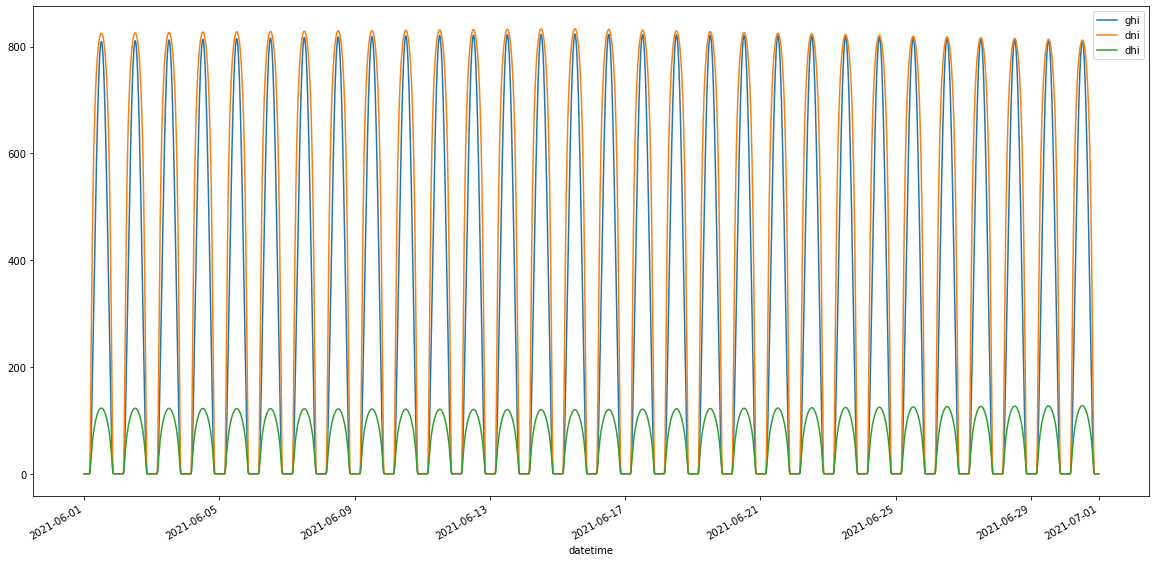

In [86]:
clearsky.plot();

In [87]:
model_chain.run_model(weather=clearsky)

ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: pvwatts_dc
  ac_model: pvwatts_inverter
  aoi_model: no_aoi_loss
  spectral_model: no_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

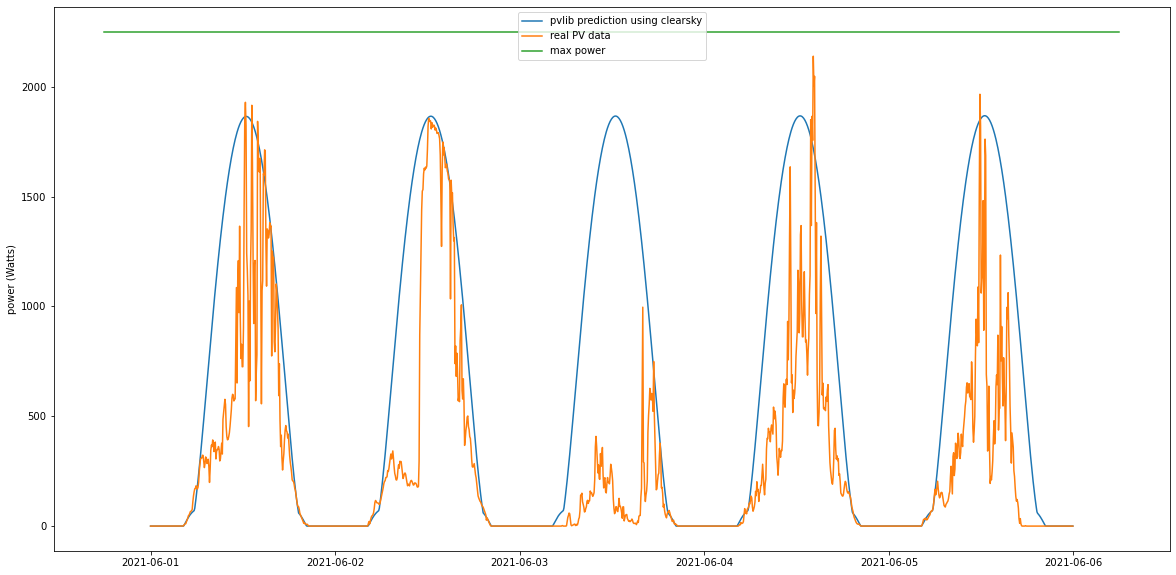

In [92]:
fig, ax = plt.subplots()
DATE = slice("2021-06-01", "2021-06-05")
ax.plot(model_chain.results.ac[DATE], label="pvlib prediction using clearsky")
ax.plot(pv_data_to_forecast[DATE], label="real PV data")
ax.plot(ax.get_xlim(), (power_watts, power_watts), label="max power")
ax.legend()
ax.set_ylabel("power (Watts)");

## Open and prepare NWP data

In [ ]:
nwp = xr.open_dataset(NWP_ZARR_PATH, engine="zarr", mode="r")
nwp

<xarray.Dataset>
Dimensions:    (variable: 17, init_time: 5319, step: 37, y: 704, x: 548)
Coordinates:
  * init_time  (init_time) datetime64[ns] 2020-01-01 ... 2021-11-08T15:00:00
  * step       (step) timedelta64[ns] 00:00:00 01:00:00 ... 1 days 12:00:00
  * variable   (variable) <U6 'cdcb' 'lcc' 'mcc' ... 'wdir10' 'prmsl' 'prate'
  * x          (x) int64 -239000 -237000 -235000 ... 851000 853000 855000
  * y          (y) int64 1223000 1221000 1219000 ... -179000 -181000 -183000
Data variables:
    UKV        (variable, init_time, step, y, x) float32 ...